 <font size="6">   Universidade de São Paulo -  USP/São Carlos
    
    Instituto de Ciências Matemáticas e de Computação - ICMC
    
    Estatística e Ciência de Dados
    
    Grupo: Flaviane Louzeiro da Silva - nUSP 11885075
    
    SCC0652 - Visualização Computacional 
    
    Projeto Prático
 
</font>


# Objetivo Geral

Neste trabalho prático pretende-se explorar a base de dados CORD-19,  afim de clusterizar os artigos. Para isso os termos mais frequentes, as nacionalidades mais citadas, a similaridade dos documentos com TF-IDF e por fim o agrupamento de documentos com o <i>k-means</i>. Dessa forma, este trabalho é divido em, pelo menos, 03 etapas.

<b> Etapa 01 - Organizando o dataframe </b>

Inicialmente será apresentada a base de dados e a estrutura original, em seguida é feito o tratamento da base de dados, realizando a validação da estrutura dos artigos analisados, organizando-os em um <i>dataframe</i>, retirando os artigos com atributos faltosos e os artigos duplicados.

<b> Etapa 02 - Exploração do dataframe e calculo de similaridade dos documentos </b>

Afim de completar a etapa anterior, será realizada a tokinização dos termos, em seguida a sumarização dos dados tratados, com os termos mais frequentes e a nuvem de palavras. Em seguinda será realizada a busca pelas entidades nomeadas, utilizando recursos de processamento de linguagem natural.

<b> Etapa 03 - Agrupamento dos documentos</b>

[Em desenvolvimento...] 


Abaixo segue os links para cada etapa.

[Etapa 01](#etapa1)

[Etapa 02](#etapa2)

[Etapa 03](#etapa3)


# Etapa 01 <a id='etapa1'></a>

## Descrição da base de dados <a id='descricao'></a>

Com o objetivo de ajudar pesquisadores e corpo médico no combate ao Covid-19, foi lançado um desafio Kaggle[1] para tratamento e busca de informações em uma base de dados formada por diversos artigos científicos relacionados ao corona vírus, o **COVID-19 Open Research Dataset (CORD-19)**.

  Atualmente, o CORD-19 possue mais de 200.000 artigos, destes pelos menos 100.000 são artigos completos, gerando em torno de 20GB. No entanto, para esta tarefa usei uma base com apenas 4GB, que contém mais de 29.000 artigos, onde pelo menos 13.000 desses são artigos completos. Esses artigos estão formatados na estrutura *.JSON*

[1] https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

[Etapa 02] (#etapa_02)

## Visualização da estrutura do dataset <a id='visualizacao'></a>
  
   O dataset CORD-19 possuem estrutura apresentada abaixo, com 4 diretórios principais. 
   <img src="figs/estruturaCORD-19.png"/>
   
   Dentro de cada diretório há os artigos em formato *JSON*. 
   <img src="figs/arquivosJSON.png" />
   
   Os artigo *.JSON* possuem estão estruturados no formato abaixo:
   <img src="figs/estrutruraJSON.png"/>
   
   Onde o título se apresenta conforme a figura a seguir
   <img src="figs/title.png"/>
   
   O resumo está contido na seguinte estrutura.
   <img src="figs/abstract.png"/>
   
   E por fim, o corpo do artigo encontra-se no formato abaixo, onde cada subseção *1,2...* contém um paragrafo da publicação.
   <img src="figs/corpo.png"/>
   
   
   Esta exploração da estrutura do arquivo é necessária pois os códigos desenvolvidos terá que alimentar um dataframe com as informações contidas em cada seção dos artigos contidos no *CORD-19*.

## Metodologia

Conforme visto em aula, a organização e seleção dos dados é a primeiro etapa do pipeline de visualização. Dessa forma a persistência dos dados é crucial nesse processo. 

Em resumo, nesta etapa será realizada a:
* inserção dos artigos em um dataframe;
* exclusão dos artigos que por ventura estejam faltando alguma seção como ID, título, resumo, corpo do texto;
* remoção de artigos duplicados

A seguir será apresentada a metodologia utilizada para manipulação do dataset, onde o objetivo é organizar o dataset em um dataframe para utilizá-lo posteriormente. 

### Instalação e carregamento das Bibliotecas

In [1]:
import pandas as pd
import glob
import json 
import seaborn as sns

### Definição da estrutura do dataframe
Inicialmente será criado um dicionário vazio, que será utilizado para buscar na base de dados os seguintes atributos nos artigos:
* a identificação (paper_id);
* o título (title)
* o resumo (abstract)
* o corpo (text)

In [2]:
dicArtigos = {'paper_id':[], 'title':[],
             'abstract':[], 'text':[]}
type(dicArtigos)

dict

Posteriormente o dicionário é transformado em dataframe, para facilitar a manipulação no decorrer do processamento.

In [3]:
dfArtigos = pd.DataFrame.from_dict(dicArtigos)
type(dfArtigos)

pandas.core.frame.DataFrame

### Listagem dos artigos contidos no dataset
Criada a estrutura, será feita uma busca recursiva pelos arquivos .json presentes no diretório com o auxílio da blibioteca de leitura de diretorio glob. Os arquivos *.json* serão lidos e o nome do arquivo será inserido na lista.

In [4]:
listaArtigos = glob.glob(f'{"./"}//**/*.json', recursive= True) 

print('Foram encontrados ',len(listaArtigos), ' artigos') # total de artigos percorrido

Foram encontrados  29315  artigos


### Carregando o dataframe
A seguir será criada a função que de fato alimentará o dataframe com os atributos definidos anteriormente.

In [5]:
## funcao que vai percorrer todos os aquivos e popular o DF
def funcao_dfArtigos(listaArtigos, df):
    for nomeArtigo in listaArtigos:
        linhaDF={'paper_id':None, 'title':None,
                 'abstract':None, 'text':None}
        
        with open(nomeArtigo) as json_data:
            
            dados = json.load(json_data)
            
            linhaDF['paper_id']=dados['paper_id'].strip() #retirando os espaços no inicio e no fim
            linhaDF['title']=dados['metadata']['title'] 
            # extração palavra por palavra do abstract
            listaAbstract = [abstract['text'] for abstract in dados['abstract']]
            abstract = '\n'.join(listaAbstract)
            linhaDF['abstract']=abstract.strip()
            # extração palavra por palavra do conteudo
            listaTexto = [text['text'] for text in dados['body_text']] 
            texto = '\n'.join(listaTexto)
            linhaDF['text']=texto.strip()
            
            df = df.append(linhaDF, ignore_index = True)
        
    return df
    

Chamada da função. Agora de fato ocorrerá a extração dos dados e insersão no dataframe.

**Observação: Este procedimento poderá demorar alguns minutos.**


In [6]:
dfArtigos = funcao_dfArtigos(listaArtigos, dfArtigos) 

In [7]:
print('O dataframe foi alimentado com ',dfArtigos.shape[0], ' artigos e ', dfArtigos.shape[1], ' atributos')

O dataframe foi alimentado com  29315  artigos e  4  atributos


In [8]:
## salvando o total de artigos para comparar
totalArtigos=dfArtigos.shape[0] 

## Verificação da Base de dados

Inicialmente será verificado no dataframe se há valores faltantes, ou seja, se no dataframe os artigos foram  alimentado com todos os atributos definidos no dicionário. 

Então, por se tratar de uma base de dados textual será será feito um mapa de calor com o auxilio da biblioteca *seaborn*. A intenção é visualmente saber em quais artigos há atributos faltantes. 

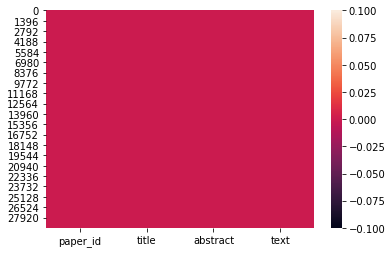

In [9]:
sns.heatmap(dfArtigos.isnull());

**Observação:** De acordo com o mapa de calor, em todos os artigos foram carregadas alguma informação em cada atributo, seja informação útil ou apenas um espaço. No entanto, conforme é possível notar no head do dataframe, há artigos sem título ou sem abstract.

In [10]:
dfArtigos.head()

,paper_id,title,abstract,text
0,c79f73c69108533aa867037948f63229d877e9fd,,,Fatty acids are covalently attached to many me...
1,90d1d04a22ec4e9f4e1e0d63053a99784ca489d6,Equine sarcoid: In situ demonstration of matri...,Sarcoids are the most prevalent equine skin tu...,Sarcoids are the most common equine skin tumou...
2,0a9145664ca5e8dd902b5f01f70a53e638ab52a9,Evaluation of a single-tube fluorogenic RT-PCR...,Bovine respiratory syncytial virus (BRSV) caus...,"Bovine respiratory syncytial virus (BRSV), a P..."
3,4564577ec73f757cb36aae29fd4c867482f84dee,Evidence and future potential of mobile phone ...,Global health threats such as the recent Ebola...,Novel sources of data coupled with new data mi...
4,bc9e8da285ed2401fb1351f9edd7891385524c31,Brown,This chapter describes how the impact of psych...,"This is an adaptive response in one sense, pro..."


#### Verificação dos atributos

Dessa forma será verificado em todas as colunas do dataframe se há algum atributo com apenas um espaço, ou seja ''

In [11]:
# verificando se há artigo sem ID
print ('Foram encontrados ',len(dfArtigos[dfArtigos['paper_id']=='']), 'artigos sem o ID')

Foram encontrados  0 artigos sem o ID


In [12]:
print ('Foram encontrados ',len(dfArtigos[dfArtigos['title']=='']),'artigos sem o título')

Foram encontrados  3583 artigos sem o título


In [13]:
print ('Foram encontrados ',len(dfArtigos[dfArtigos['abstract']=='']), 'artigos sem o resumo')

Foram encontrados  8051 artigos sem o resumo


In [14]:
print ('Foram encontrados ',len(dfArtigos[dfArtigos['text']=='']),'artigos sem conteúdo')

Foram encontrados  0 artigos sem conteúdo


#### Remoção dos artigos  
Feita as verificações, será excluído da base de dados os artigos com informações faltantes

In [15]:
## apagando os artigos que faltam informações
dfArtigos = dfArtigos[dfArtigos['title'] != ''] # deixando somente os artigos que tem titulo

In [16]:
dfArtigos = dfArtigos[dfArtigos['abstract'] != ''] # deixando somente os artigos que tem abstract

In [17]:
print('Haviam ', totalArtigos,'após a limpeza ficaram, ', dfArtigos.shape[0],'artigos')

Haviam  29315 após a limpeza ficaram,  20343 artigos


#### Removendo os artigos duplicados
Por fim, usando a função do pandas *drop_duplicates*, será removido os artigos que estejam duplicados no dataframe.

In [18]:
# remoção de artigos duplicados, o inplace = true remove e atualiza o df
dfArtigos.drop_duplicates(['abstract','text','title'], inplace=True)

In [19]:
dfArtigos.shape

(20211, 4)

In [20]:
print('Haviam ', totalArtigos, 'artigos, após todas as verificações restaram ', dfArtigos.shape[0],'artigos')
print('Uma redução de',round(100-dfArtigos.shape[0]*100/totalArtigos), '% da base de dados')

Haviam  29315 artigos, após todas as verificações restaram  20211 artigos
Uma redução de 31 % da base de dados


## Salvando o dataframe

Salvando o dataframe para o envio no Edisciplinas

In [21]:
#dfArtigos.to_csv('dfArtigos_completo.csv')

## Conclusão

O tratamento da base de dados foi o primeiro passo dado. A base de dados é textual e, conforme apresentado anteriormente, houve uma redução de 31% após a verificação da base de dados. Com isso, verificou-se a importância da realização da persistência dos dados, visto que, embora o desafio siga regras e possivelmente tenha seguido uma política controle na inserção dos artigos no dataset, houveram artigos com seções faltosas além de artigos duplicados.

# Etapa 02 <a id='etapa2'></a>

## Objetivo 

Identificar o grupo taxonômico dos dados, apresentar e avaliar o mapeamento visual apropriado. No entanto, para isso é necessário concluir a etapa anterior. Dessa forma, será dada continuidade no tratamento, realizando a tokinização e sumarização dos dados, apresentando-os  em uma nuvem de palavras e uma tabela com os termos mais frequentes. Para isso, além pré processamento já realizado, será necessário inicialmente tratar os dados com bibliotecas de processamento natural 
    

## Amostragem da base

Embora já tenha ocorrido uma redução de 31% dos artigos após o pré processamento. Ainda há muitos artigos, o que resultou em um travamento de minha máquina. Dessa forma, daqui em diante, será trabalhado apenas com uma amostra do dataset, essa amostra foi retirada aleatoriamente da base de dados com 500 artigos. E, para que o processo possa ser repetido, será fixado o random_state = 123.

In [22]:
dfArtigos_amostra = dfArtigos.sample(n=500, random_state=123)

In [23]:
dfArtigos_amostra.shape # checando a estrutura do dataframe

(500, 4)

In [24]:
dfArtigos_amostra.head() # checando os 5 primeiros

,paper_id,title,abstract,text
10258,113db0415367edaa4506fa09c05baf513fbbf9e1,Neutrophil-derived chemokines on the road to i...,"During recent years, it has become clear that ...","Chemokines are 8-to 12-kDa polypeptides, shari..."
29155,ae66f22f886d3b019934ae237c11a5fb53dbefb2,Prediction of receptorome for human-infecting ...,The virus receptor is key for viral infection ...,Receptor-binding is the first step for viral i...
22095,14f427656a9898ce76f31cb012f258a9aa6d1ce3,Establishment a real-time reverse transcriptio...,Bovine paratuberculosis (PTB) is a chronic ent...,Introduction Johne's disease (JD) is a chronic...
8356,b47cabaad947b93b9ede711028233cc0c9077ea8,"Design, synthesis, and bioevaluation of viral ...",Keywords: Viral 3C and 3C-like protease inhibi...,"Viruses that belong to the Picornaviridae, Cal..."
1170,ca18e923f1cd6532ba1a7f05ca8e2abfa940834a,Clinical Trials and Novel Pathogens: Lessons L...,During the recent global outbreak of severe ac...,T he recognition of SARS as a transmissible di...


### Uso da biblioteca científica

Por se tratar de uma base de dados com artigos científicos, o inglês é a língua padrão e acredita-se que há uma baixa taxa de erros, visto que seguem regras bem explícitas pois são  publicados em revista.

Será utilizada a biblioteca **spacy**, que é uma biblioteca para processamento avançado de linguagem natural, sendo bastante utilizada para analisar textos. Nela há o modelo **en_core_sci_md** já treinado na para o jargão médico. 

Dentre as funcionalidades do modelo há uma lista de stop words, que é uma lista de termos não representativos para um documento, geralmente essa lista é composta por: preposições, artigos, advérbios, números, pronomes e pontuação.

In [25]:
#### instalação das bibliotecas - Se necessário
#pip install spacy
#pip install scispacy
#pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_md-0.2.5.tar.gz

In [26]:
import spacy
import scispacy
import en_core_sci_md #fazer download na cell acima

A seguir, será criado o modelo, onde serão desabilitados alguns parametros para facilitar o processamento. Além disso será definido o tamanho máximo de 2000000 caracteres a serem analisados em cada artigo.

In [27]:
modelo = en_core_sci_md.load(disable=['tagger', 'parser', 'ner'])
modelo.max_lenght = 2000000

In [28]:
stopWords = ['al', 'al.','et','show','fig','fig.','mrna', 'sirna','neutrophil', 'ns2b','ligand']
for w in stopWords:
    modelo.vocab[w].is_stop = True


### Extração e limpeza dos termos nos Textos

Para a maioria dos tipos de processamento lingüístico é necessário identificar e categorizar as palavras de um texto, para isso é realizada a extração e limpeza dos termos, onde cada documento vai ter o seu conteúdo dividido em cada palavra significantiva presente no documento.

Primeiro  é realizada a tokenização para decompor o documento em cada termo que o compõe, delimitando o espaço em branco entre os termos, quebras de linhas, tabulações, e alguns caracteres especiais. 

Além disso, é feita a limpeza, onde são removidos as stop words, depois é apliacada a lematização  que é o método para redução de um termo ao seu radical, removendo as desinências, afixos, e vogais temáticas, dessa forma os termos derivados de um mesmo radical serão contabilizados como um único termo.

In [29]:
def tokinizacao(sentenca):
    sentenca = sentenca.lower() # colocando miusculo
    
    #lematização 
    lista = []
    lista = [palavra.lemma_ for palavra in modelo(sentenca) if not (palavra.is_stop      #removendo as stop_words e
                                                                   or palavra.like_num   #os numeros
                                                                   or palavra.is_punct   # pontuacao
                                                                   or palavra.is_space   # espaços excedentes 
                                                                   or len(palavra)== 1   # com tamanho 1 caractere                                                       
                                                                   )] 
    
    lista = ' '.join([str(palavra) for palavra in lista]) #concatenando as palavras
    
    
    return lista


Testando a função no primeiro artigo da amostra

In [30]:
teste = dfArtigos_amostra['text'][10258] 
print('Antes da tokinizaçao: ', len(teste), ' palavras')
print('Após a tokinização: ', len(tokinizacao(teste)),' palavras')
print('Uma redução de ', round(len(tokinizacao(teste))/len(teste)*100,2), '%')

Antes da tokinizaçao:  37220  palavras
Após a tokinização:  25683  palavras
Uma redução de  69.0 %


Testada a função, agora será aplicada em todos os atributos 'text' dos artigos do dataframe

In [31]:
dfArtigos_amostra['text'] = dfArtigos_amostra['text'].apply(tokinizacao)

## Sumarização 

### Termos frequentes - Tabela de Frequencia
Será usada a biblioteca NLTK, no entanto ela precisa que as entradas estejam em txt, assim, inicialmente será criado um txt para cada artigo.

In [32]:
for index, row in dfArtigos_amostra.iterrows(): #percorendo as linhas do DF
    artigoTXT = open('corpus/'+row['paper_id']+'.txt', 'w') # criando o .txt
    n = artigoTXT.write(row['text'])# excrevendo no .txt
    artigoTXT.close()

criando o Corpus

In [33]:
import nltk
from nltk.corpus import PlaintextCorpusReader
corpus = PlaintextCorpusReader('corpus', '.*')

In [34]:
n = corpus.words()
print('Há ',len(n), ' palavras no corpus')

Há  1329762  palavras no corpus


In [35]:
frequenciaPalavra = nltk.FreqDist(n) # distribuição de frequencia
maisFrequentes = frequenciaPalavra.most_common(100) # 100 mais comuns
maisFrequentes

[('-', 53960),
 (',', 17577),
 ('cell', 11589),
 ('.', 9745),
 ('virus', 9195),
 ('/', 8532),
 ('1', 8337),
 ('protein', 7984),
 ('2', 7690),
 ('study', 6861),
 ('infection', 6783),
 ('viral', 4507),
 ('3', 4323),
 ('show', 4311),
 ('result', 4184),
 ('sequence', 3944),
 ('gene', 3765),
 ('high', 3754),
 ('disease', 3579),
 ('datum', 3349),
 ('group', 3216),
 ('sample', 3128),
 ('human', 3098),
 ('increase', 3040),
 ('include', 3006),
 ('patient', 2983),
 ('test', 2858),
 ('time', 2796),
 ('analysis', 2722),
 ('mouse', 2701),
 ('rna', 2676),
 ('control', 2668),
 ('case', 2640),
 ('response', 2636),
 ('find', 2607),
 ('model', 2572),
 ('report', 2560),
 ('expression', 2539),
 ('different', 2527),
 ('level', 2527),
 ('table', 2404),
 ('type', 2297),
 ('infect', 2291),
 ('bind', 2283),
 ('day', 2251),
 ('antibody', 2240),
 ('activity', 2235),
 ('health', 2189),
 ('sars', 2189),
 ('method', 2172),
 ('low', 2151),
 ('effect', 2143),
 ('4', 2137),
 ('figure', 2135),
 ('influenza', 2133),
 ('

### Termos Frequentes - Nuvem de Palavras

In [36]:
#pip install wordcloud
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

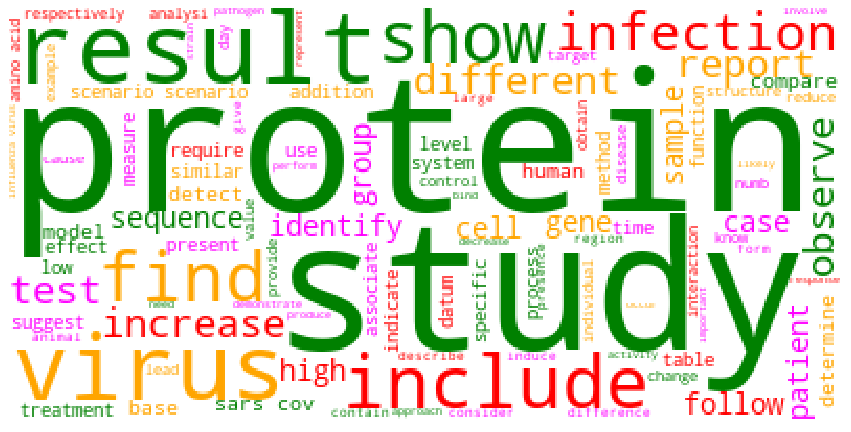

In [37]:
coresMapa = ListedColormap(['orange', 'green', 'red','magenta']) # cores do mapa
nuvemPalavras = WordCloud(background_color = 'white', max_words= 100, colormap = coresMapa)
nuvemPalavras = nuvemPalavras.generate(dfArtigos_amostra['text'].str.cat(sep='\n'))
plt.figure(figsize = (15,15))
plt.imshow(nuvemPalavras)
plt.axis('off') # sem eixo x e y
plt.show()

## Insight - Extração de entidades nomeadas

Utilizando recursos de processamento de linguagem natural, através da biblioteca spacy, será realizada a contagem dos países e nacionalidades mais citadas na amostra, fazendo busca pelas entidades nomeadas do tipo [GPE](https://spacy.io/api/annotation), ou seja, os paises, cidades e nacionalidades mais citadas na amostra. 

Para isso, será criando um modelo de reconhecimento de entidade na língua inglesa, com tamanho máximo de 2000000 caracteres.



In [38]:
nlp_entidade = spacy.load('en')
nlp_entidade.max_length = 2000000

In [39]:
gpe = []
for index, row in dfArtigos_amostra.iterrows():
    text = row['text']
    doc = nlp_entidade(text)
    for entidade in doc.ents:
        if entidade.label_ == 'GPE':
            gpe.append(str(entidade.text))
    

Entidades com mais de 50 citadas

In [40]:
import numpy as np
gpe_valor, gpe_qtd = np.unique(np.array(gpe), return_counts = True)
dfGPE = pd.DataFrame({'valor':gpe_valor, 'qtd': gpe_qtd})
dfGPE_filtrado = dfGPE[dfGPE.qtd>50].sort_values(by='qtd', ascending=False)

Barplot das 10 entidades nomeadas mais citadas

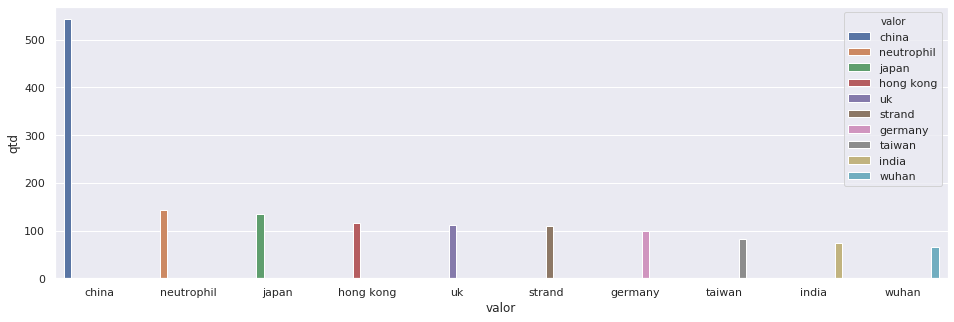

In [41]:
sns.set(rc={'figure.figsize':(16,5)})
sns.barplot(x= 'valor', y='qtd', hue='valor', data = dfGPE_filtrado[:10]);

### TF-IDF (Term Frequency - Inverse Document Frequency)

Para pontuar a importância de uma palavra em um documento com base na frequência com que ela apareceu. Para isso, será usada a base de dados completa.

In [42]:
#dfArtigos = pd.read_csv('corona_df_completo.csv')
#dfArtigos = dfArtigos.dropna()

#dfArtigos.to_csv('dfArtigos_completo.csv')
#textosArtigos = dfArtigos['text'].tolist()

In [43]:
dfArtigos = pd.read_csv('dfArtigos_completo.csv')
textosArtigos = dfArtigos['text'].tolist()

In [44]:
dfArtigos.shape

(20209, 6)

Vetorização 

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer 
tfdif = TfidfVectorizer(max_features=2**12) # para evitar estouro de memoria
artigosVet = tfdif.fit_transform(textosArtigos)

Redução de dimensionalidade com PCA (<i>Principal Componet Analysis </i>) para vizualizar a dispersão dos artigos

In [46]:
from sklearn.decomposition import PCA
pca = PCA (n_components=2) # 2 componentes
x_pca = pca.fit_transform(artigosVet.toarray())

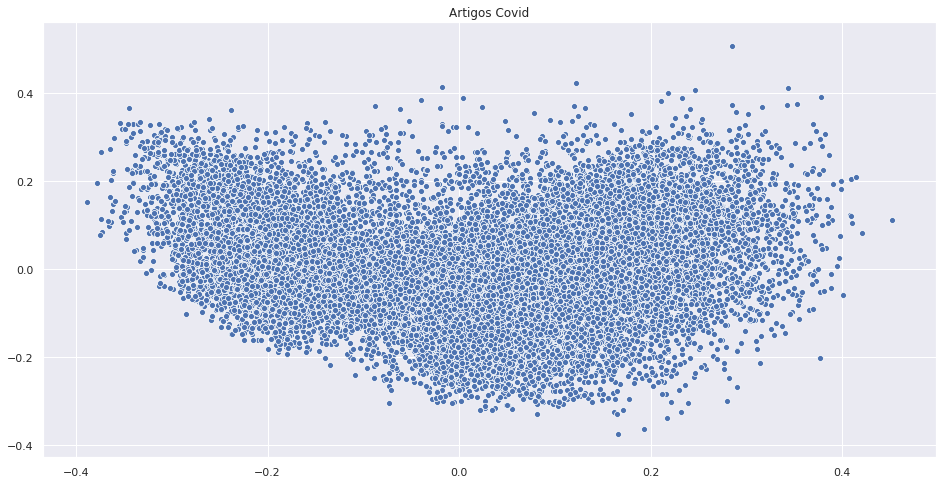

In [47]:
sns.set(rc={'figure.figsize':(16,8)})
sns.scatterplot(x_pca[:,0],x_pca[:,1])
plt.title('Artigos Covid');

## Conclusão

Conforme já apresentado, este trabalho consiste na exploração do dataset CORD-19 que é um conjunto de artigos publicados sobre o Covid-19. Nesta etapa, obteve-se o insight de conhecer as nacionalidades mais citadas na amostra aleatória, através das entidades nomeadas. E assim, o grupo taxonômico destes dados é categórico, conforme exibido no barplot.

Por ser uma base textual, optou-se por visualizar os termos mais frequentes através de uma nuvem de palavras da amostra coletada. Além disso, para a base completa, realizou-se a pontuação da importância de uma palavra no artigo, com base na frequência com que ela apareceu através da técnica <i>TF-IDF</i>, por fim para visualizar a dispersão dos artigos com base na pontuação, reduziu-se a dimensionalidade para 2 e exibiu-se o gráfico de dispersão.

Para a próxima etapa, pretende-se realizar o agrupamento dos artigos através da técnica <i>k-means</i>.

# Etapa 03 <a id='etapa3'></a> 

<b>Agrupamento com k-means</b>

In [1]:
import pandas as pd

In [2]:
teste = pd.read_csv('dfArtigos_completo.csv')

In [5]:
teste.shape[0]*0.9

18188.100000000002

In [7]:
teste = teste.sample(n=15000, random_state=123)

In [8]:
teste.to_csv('teste.csv')

[Em desenvolvimento...]